# **MONTE CARLO METHODS AND FINITE-SIZE ANALYSIS IN PARAMAGNETIC-FERROMAGNETIC MODELS OF PHASE TRANSITION**

Authors:
* Carlo Divari
* Gloria Isotton
* Maryam Feizi
* Sara Munafò

In [71]:
import numpy as np
import matplotlib.pyplot as plt

# **INTRODUCTION**

In [ ]:
#introduction

In [ ]:
#ising

In [ ]:
#metropolis 

In [ ]:
#blablabla

# **SIMULATION OF A 2D ISING MODEL**

In [ ]:
def Ising(N, beta, eq_steps = int(1e4), steps = int(1e6), order = False, annealing = False, cluster = False, verbose=True):
    '''
    Run a simulation of a 2d Ising model

    Parameters:
    - N: number of sites per dimension
    - beta
    - eq_steps: initial steps for the equilibration phase
    - steps: effective steps of the simulation
    - order: generate a ordered configuration with uniform magnetisation
    - annealing: using simulating annealing during equilibration
    - cluster: to use the Wolff algorithm
    - verbose: more detailed output during simulation
    
    Output:
    - E_mean: Mean energy 
    - M_mean: Mean magnetization
    - Cs: Specific heat
    - Chis: Susceptibility
    - E_var: Energy error
    - M_var: Magnetisation error
    - E_eq: Energy on equilibration
    - M_eq: Magnetisation on equilibration
    - E: Energy on simulation
    - M Magnetisation on simulation

    '''
    
    if verbose:
        print('---------- ISING MODEL ----------')
        print('N:', N, ', beta:', beta, ', cluster:', cluster, ', annealing:', annealing , '\n')

        print('Start equilibration...')

  # Init state
    if order:
        curr_state = np.ones((N,N))
    else:
        curr_state = init_state(N)

    E_eq = np.zeros(eq_steps)
    M_eq = np.zeros(eq_steps)
  
    if annealing:
        ### Equilibation with SA
        betas = np.zeros(eq_steps)
        N_annealing = eq_steps-eq_steps//10
        betas[:N_annealing] = np.linspace(0.1, beta, num=N_annealing, endpoint=True)
        betas[N_annealing:] = beta
    else:
    ### Equilibration
        betas = np.zeros(eq_steps) + beta
      
  # Loop over time steps
    if verbose:
        for i in tqdm(range(eq_steps)):
            #keep trace of energy and magnetisation
            E_eq[i] = energy(curr_state)
            M_eq[i] = np.sum(curr_state)
            #update the state
            if cluster:
                curr_state = wolff(curr_state, betas[i])         
            else:
                curr_state = glauber(curr_state, betas[i])

        print('End equilibration...\n')
    
    else:
        for i in range(eq_steps):
            #keep trace of energy and magnetisation
            E_eq[i] = energy(curr_state)
            M_eq[i] = np.sum(curr_state)
            #update the state
            if cluster:
                curr_state = wolff(curr_state, betas[i])         
            else:
                curr_state = glauber(curr_state, betas[i])
        
  ### Simulation
    if verbose:  
        print('Start simulation...')

  # Define arrays for storing state observables
    E = np.zeros(steps)
    M = np.zeros(steps)
  
    if verbose:
        for i in tqdm(range(steps)):
            #keep trace of energy and magnetisation
            E[i] = energy(curr_state)
            M[i] = np.sum(curr_state)
            # Evolve state
            if cluster:
                curr_state = wolff(curr_state, beta)
            else:
                curr_state = glauber(curr_state, beta)
        print('End simulation...')
    
    else:
        for i in range(steps):
          #keep trace of energy and magnetisation
            E[i] = energy(curr_state)
            M[i] = np.sum(curr_state)
          # Evolve state
            if cluster:
                curr_state = wolff(curr_state, beta)
            else:
                curr_state = glauber(curr_state, beta)

    ### Compute observables
    E_mean, M_mean, C, Chi = np.mean(E), np.mean(M), beta**2*np.std(E)**2, beta*np.std(M)**2
    E_var, M_var = np.std(E), np.std(M)

  ### Return results
    return (E_mean, M_mean, C, Chi,
            E_var, M_var,
            E_eq, M_eq, E, M) 






N_T = 40
Ts = np.linspace(0.75, 3.75, endpoint=True, num=N_T)
betas = 1 / Ts

Ns = [10,20,30,40,50]
N_N = len(Ns)
eq_steps = int(1e4)
steps = int(1e4)

Es = np.zeros((N_N, N_T))
Ms = np.zeros((N_N, N_T))
Cs = np.zeros((N_N, N_T))
Chis = np.zeros((N_N, N_T))

for i,N in enumerate(Ns):
  print('Simulating N={}'.format(N))
  for j, beta in enumerate(tqdm(betas)):
    #print('\t{}/{}  beta: {}'.format(j,N_T,beta))
    E_mean, M_mean, C_mean, Chi_mean, E_var, M_var, E_eq, M_eq, E, M,  = Ising( N, beta, eq_steps=eq_steps, steps=steps, annealing=False, cluster=False,verbose=False  )

    Es[i,j] = E_mean
    Ms[i,j] = M_mean
    Cs[i,j] = C_mean
    Chis[i,j] = Chi_mean

In [79]:
#define variables
L=40   #dimension of the squared matrix
time_f=20
T=2 #KbT
J=1
step=1
realiz=10 #mc means
nt=10  #number of temperatures

In [73]:
#Create a nxn lattice with random spin configuration
def init_lattice(n):
    lattice = np.random.choice([1, -1], size=(n, n))
    return lattice

In [74]:
#define pbc
def bc(i):
    if i>L-1: 
        return 0
    if i<0:
        return L-1
    else:
        return i

In [75]:
#compute some useful variables

def energy(state):
    
    '''define the energy at a given configuration'''
    
    N = state.shape[0]
    energy = 0
  
    for i in range(N):
        for j in range(N):

      # get nearest neighbours states
            nn = state[bc(i-1), j] + state[bc(i+1), j] + state[i, bc(j-1)] + state[i, bc(j+1)]
            energy +=  -state[i,j] * nn
    return energy / 2 
    
    
def magnetization(state,L):
    
    '''define the magnetization per site'''
    
    Magn = np.sum(state)/(L*L)    
    return Magn


def delta(s,a,b):
    
    '''define delta E between 2 spin configurations'''

    return 2*s[a][b]*(s[a][int(bc(b+1))]+s[a][int(bc(b-1))]+s[int(bc(a+1))][b]+s[int(bc(a-1))][b])   #consider only nearest neighbours

In [76]:
# Define arrays to store state observables
E = np.zeros(nt)
M = np.zeros(nt)
C = np.zeros(nt)
Chi = np.zeros(nt)
Te = np.linspace(0.1,5,nt)

for i in range(len(Te)):
    T=Te[i]
    mag=np.zeros(time_f)
    ene=np.zeros(time_f)
    for r in range(0,realiz):
        s=np.ones((L,L))  #ground state
        for t in range(0,time_f):
            m=magnetization(s,L)
            mag[t]=mag[t]+m/realiz
            ene[t]=energy(s)
            for count in range(0,int(L*L/step)): #montecarlo attempt
                a=np.random.randint(0,L)
                b=np.random.randint(0,L)
                x=np.random.random()
                delta_E=delta(s,a,b)  
                if x<0.5*(1-np.tanh(delta_E/(2*T))): s[int(bc(a)),int(bc(b))]=-s[int(bc(a)),int(bc(b))]
    #keep trace of energy and magnetisation
    M[i]=mag[time_f-1]
    E[i]=np.mean(ene,axis=0)/(L*L)
    C[i] = len(ene)*pow(np.std(ene),2)/(pow(L,2)*pow(T,2))
    Chi[i] = len(mag)*pow(np.std(mag),2)/(pow(L,2)*T)
    print(i)

#plt.plot(Te,M,'bo')
#plt.xlabel('Temperature')
#plt.ylabel('Magnetisation')

0
1
2
3
4
5
6
7
8
9


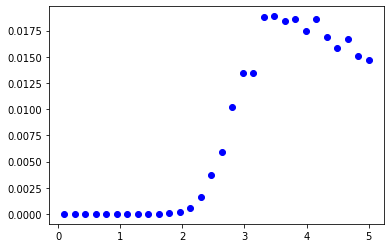

In [54]:
Te = np.linspace(0.1,5,nt)
plt.plot(Te,Chi,'bo')

In [77]:
def plot_values (Te,E,M,C,Chi,L):
    titles=['Energy','Magnetisation','Specific Heat','Susceptibility']
    physical_quantities=[E,M,C,Chi]
    col_map = np.array(["navy", "red", "green", "orange"])
    plt.figure(figsize=(16,10))
    for i in range(len(physical_quantities)):
        ax=plt.subplot(2,2,i+1)
        ax.set_xlabel('Temperature', fontsize=18)
        ax.set_ylabel(titles[i], fontsize=18)
        ax.set_title(titles[i], fontsize = 20, fontweight = "bold" )
        ax.grid('--', alpha= 0.7)
        ax.plot(Te, physical_quantities[i], '.',markersize=7, label=titles[i], alpha=0.7,color=col_map[i])
        ax.legend()
            
    plt.subplots_adjust(hspace=0.3)

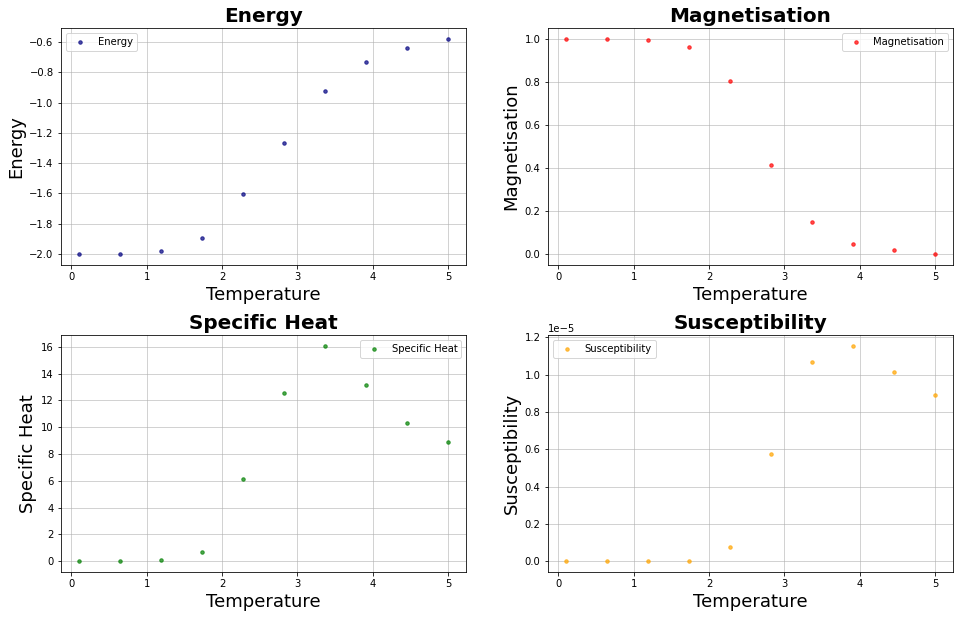

In [78]:
plot_values(Te,E,M,C,Chi,L)